In [1]:
import numpy as np
from fractions import Fraction as frac
from matplotlib import pyplot as plt
import pandas as pd
from flatsurf import *
import numpy as np
from matplotlib import pyplot as plt
import os
import pwlf
import os
from surface_dynamics.all import *
from Library import *
from Library import Section
import math
from time import time
import copy
from scipy import integrate
import sympy as sym
from sympy import Symbol
from sympy import solve, lambdify, Eq
import traceback
import dill
Integer = int

In [2]:
def print_secs(secs, den):
    j = 0
    for sec in secs:
        j+=1
        output = str(j) + ".\n"
        output = output + "x0 = " + str(simplify(sec.vec[0][0], den)) + ";\n"
        output = output + "y0 = " + str(simplify(sec.vec[1][0], den)) + ";\n"
        output = output + "\n"
        output = output + "top = " + str(simplify_eq(sec.top[0], den)) + ";\n"
        for i in range(len(sec.bottom)):
            output = output + "bottom" + str(i+1) + " = " + str(simplify_eq(sec.bottom[i], den)) + ";\n"
        for i in range(len(sec.points_bottom)):
            if i == 0:
                continue
            output = output + "point" + str(i) + " = " + str(simplify(sec.points_bottom[i], den)) + ";\n"
        output = output + "left = " + str(simplify(sec.points_bottom[0], den)) + ";\n"
        print(output)
        print("--------------------------------------------------\n")

def print_secs2(secs):
    j = 0
    for sec in secs:
        j+=1
        output = str(j) + ".\n"
        output = output + "x0 = " + str(sec.vec[0][0]) + ";\n"
        output = output + "y0 = " + str(sec.vec[1][0]) + ";\n"
        output = output + "\n"
        output = output + "top = " + str(sec.top[0]) + ";\n"
        for i in range(len(sec.bottom)):
            output = output + "bottom" + str(i+1) + " = " + str(sec.bottom[i]) + ";\n"
        for i in range(len(sec.points_bottom)):
            if i == 0:
                continue
            output = output + "point" + str(i) + " = " + str(sec.points_bottom[i]) + ";\n"
        output = output + "left = " + str(simplify(sec.points_bottom[0], 20)) + ";\n"
        print(output)
        print("--------------------------------------------------\n")

def print_secs_true(secs):
    j = 0
    for sec in secs:
        j+=1
        output = str(j) + ".\n"
        output = output + "x0 = " + str(sec.vec[0][0]) + ";\n"
        output = output + "y0 = " + str(sec.vec[1][0]) + ";\n"
        output = output + "\n"
        output = output + "top = " + str(sec.top[0]) + ";\n"
        for i in range(len(sec.bottom)):
            output = output + "bottom" + str(i+1) + " = " + str(sec.bottom[i]) + ";\n"
        for i in range(len(sec.points_bottom)):
            if i == 0:
                continue
            output = output + "point" + str(i) + " = " + str(sec.points_bottom[i]) + ";\n"
        output = output + "left = " + str(sec.points_bottom[0]) + ";\n"
        print(output)
        print("--------------------------------------------------\n")

def simplify_eq(expr, den):
    dict = expr.as_coefficients_dict()
    b = dict[1]
    m = dict[x]

    m1 = None
    b1 = None

    m_num = None
    m_den = None
    b_num = None
    b_den = None
    
    m_diff = 1
    b_diff = 1
    m_decimal = m - int(m)
    b_decimal = b - int(b)
    
    for i in range(den, 0, -1):
        for j in range(i+1):
            if(m < 0):
                m_result = abs(j/i + m_decimal)
            else:
                m_result = abs(j/i - m_decimal)

            if(b < 0):
                b_result = abs(j/i + b_decimal)
            else:
                b_result = abs(j/i - b_decimal)

            if(m_result <= m_diff):
                m_diff = m_result
                if (m < 0):
                    m_num = int(m)*i - j
                    m_den = i
                else:
                    m_num = int(m)*i + j
                    m_den = i

            if(b_result <= b_diff):
                b_diff = b_result
                if (b < 0):
                    b_num = int(b)*i - j
                    b_den = i
                else:
                    b_num = int(b)*i + j
                    b_den = i
                    
    if(m_den == 1):
        m1 = str(m_num)
    else:
        m1 = str(m_num) + "/" + str(m_den)

    if(b_den == 1):
        b1 = str(b_num)
    else:
        b1 = str(b_num) + "/" + str(b_den)
        
    return  m1 + "*x + " + b1

def simplify(m, den):

    m1 = None

    m_num = None
    m_den = None
    
    m_diff = 1
    m_decimal = m - int(m)
    
    for i in range(den, 0, -1):
        for j in range(i+1):
            if(m < 0):
                m_result = abs(j/i + m_decimal)
            else:
                m_result = abs(j/i - m_decimal)

            if(m_result <= m_diff):
                m_diff = m_result
                if (m < 0):
                    m_num = int(m)*i - j
                    m_den = i
                else:
                    m_num = int(m)*i + j
                    m_den = i
                    
    if(m_den == 1):
        m1 = str(m_num)
    else:
        m1 = str(m_num) + "/" + str(m_den)
        
    return  m1

In [9]:
# 7-0, 7-3, 7-7, 7-19, 7-29, 7-41
n_squares = 7
index = 60
j = 0
dx = 0.0005

In [10]:
permutations = perms_list(n_squares)
perm = permutations[index]

# vec_file = "vecs" + str(n_squares) + "-" + str(index) + ".npy"
# vecs0 = load_arrays_from_file(os.path.join("vecs", vec_file))

# with open(os.path.join("results", f"{n_squares} - {index}", "setup.dill"), 'rb') as f:
#     loaded_data = dill.load(f)
# a,c,e,g = loaded_data

# df = read_df(n_squares, index, j)

# with open(os.path.join("results", f"{n_squares} - {index}", f"secs - {j}.dill"), 'rb') as f:
#     secs = dill.load(f)
# with open(os.path.join("results", f"{n_squares} - {index}", f"secs_integrals - {j}.dill"), 'rb') as f:
#     secs2 = dill.load(f)

In [11]:
perm.veech_group().cusps()

[Infinity, 0, 5/2, 2/3, 3/5, 1, 17/6, 3]

In [27]:
j = 2
list_as = []
list_cs = []
list_es = []
for a_, c_, e_ in zip(a, c, e):
    list_as.append(a_[j])
    list_cs.append(c_[j])
    list_es.append(e_[j])

# Sort a, c, and e together based on the absolute value of the lower-right entry of c
sorted_pairs = sorted(zip(list_as, list_cs, list_es), key=lambda pair: abs(pair[1][1, 1]) + abs(pair[1][1,0]))

# Unzip back into separate sorted lists
sorted_a, sorted_c, sorted_e = zip(*sorted_pairs)

# Convert tuples to lists (optional)
sorted_a = list(sorted_a)
sorted_c = list(sorted_c)
sorted_e = list(sorted_e)

In [28]:
sorted_c

[array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/5],
        [-5, 14]], dtype=object),
 array([[0, 1/19],
        [-19, -4]], dtype=object),
 array([[0, 1/23],
        [-23, 42]], dtype=object),
 array([[0, 1/23],
        [-23, 42]], dtype=object)]

In [14]:
sorted_arrays

[array([[0, 1/3],
        [-3, -1]], dtype=object),
 array([[0, 1/4],
        [-4, 7]], dtype=object),
 array([[0, 1/4],
        [-4, 7]], dtype=object),
 array([[0, 1/4],
        [-4, 7]], dtype=object),
 array([[0, 1/4],
        [-4, 7]], dtype=object),
 array([[0, 1/4],
        [-4, 7]], dtype=object),
 array([[0, 1/21],
        [-21, -11]], dtype=object),
 array([[0, 1/17],
        [-17, 49]], dtype=object),
 array([[0, 1/32],
        [-32, 53]], dtype=object),
 array([[0, 1/79],
        [-79, 227]], dtype=object)]

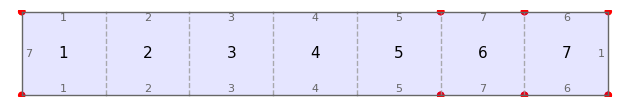

In [5]:
perm.show()

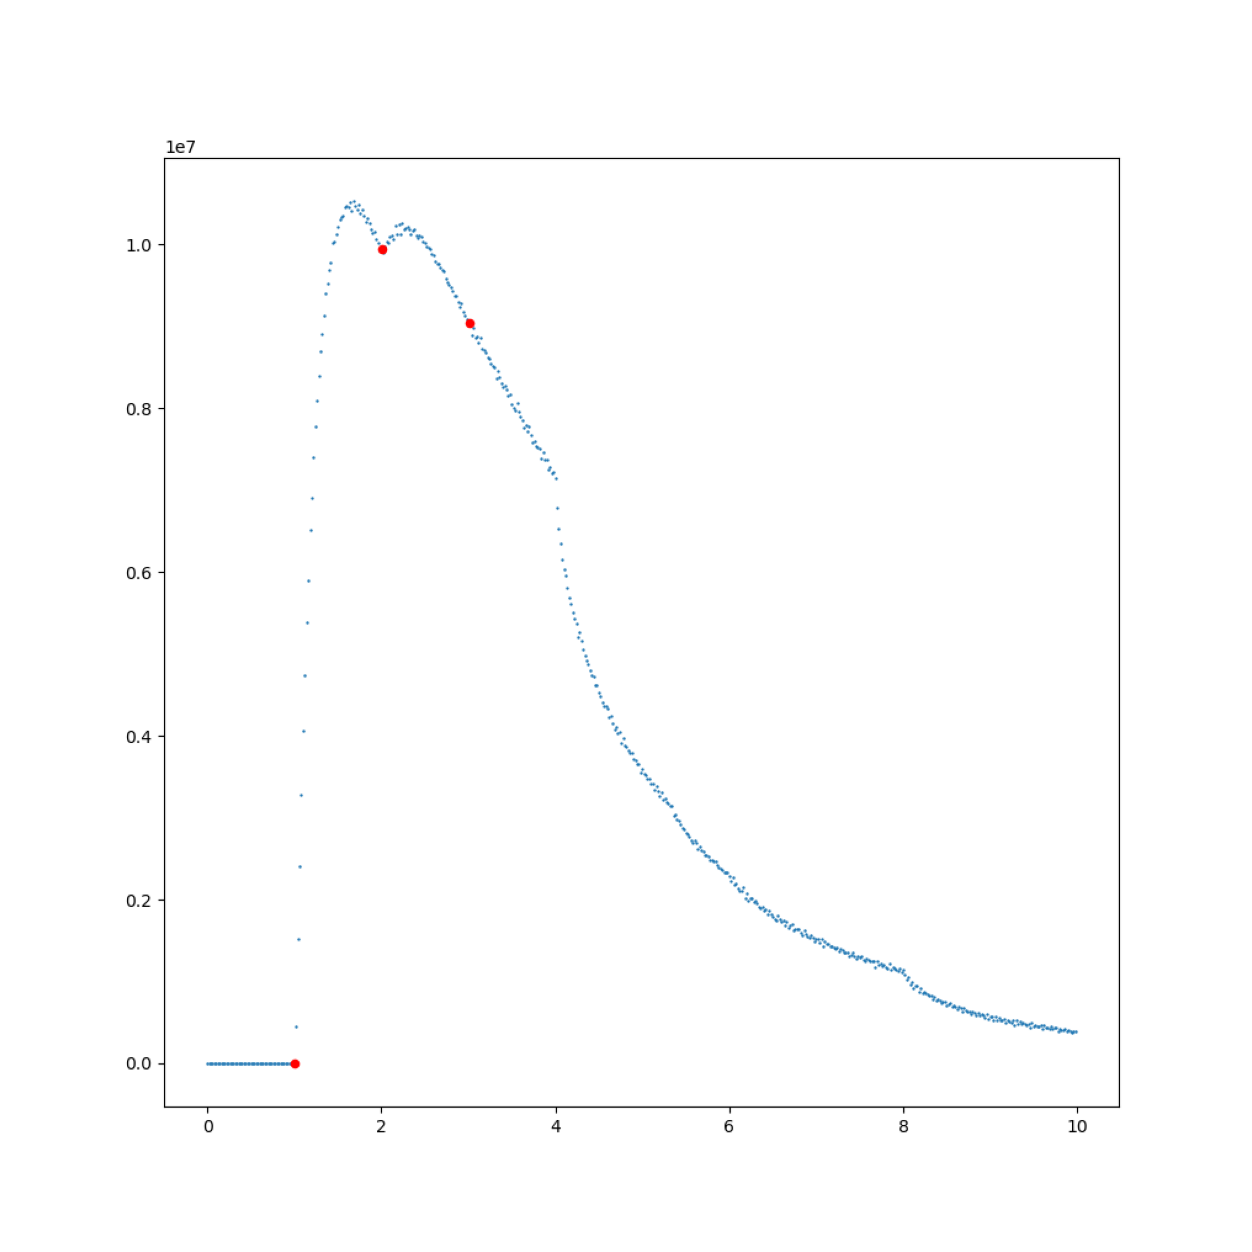

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your saved PNG file
image_path = os.path.join("results", f"{n_squares} - {index}", f"pdf - {j}.png")

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)

plt.figure(figsize=(20, 16))  # Adjust the numbers to make the image bigger (width, height in inches)

plt.imshow(img)
plt.axis('off')  # Remove axes for cleaner display
plt.show()


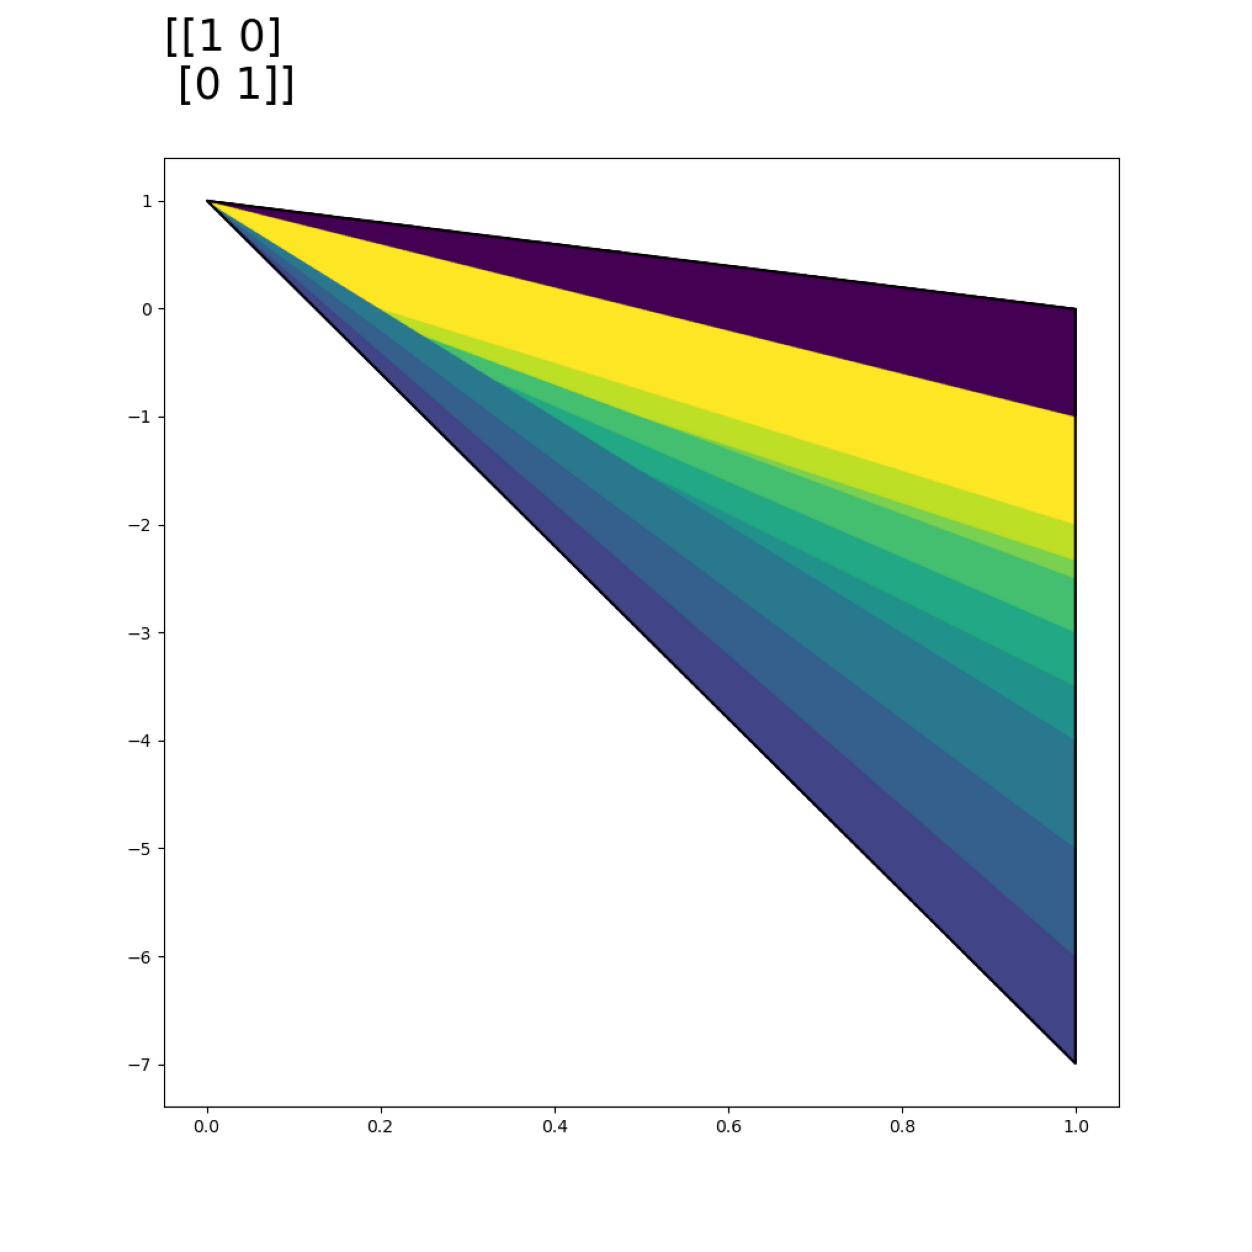

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your saved PNG file
image_path = os.path.join("results", f"{n_squares} - {index}", f"section - {j}.png")

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)

plt.figure(figsize=(20, 16))  # Adjust the numbers to make the image bigger (width, height in inches)

plt.imshow(img)
plt.axis('off')  # Remove axes for cleaner display
plt.show()

In [247]:
print_secs2(secs2)

1.
x0 = 32/11;
y0 = 2;

top = 1/2 - 16*x/11;
bottom1 = 1/2 - 43*x/22;
left = 0;

--------------------------------------------------

2.
x0 = 31/22;
y0 = 2;

top = 1/2 - 31*x/44;
bottom1 = 1/2 - 21*x/22;
left = 0;

--------------------------------------------------

3.
x0 = 21/11;
y0 = 2;

top = 1/2 - 21*x/22;
bottom1 = 1/2 - 16*x/11;
bottom2 = 1/4 - 95*x/88;
point1 = 2/3;
left = 0;

--------------------------------------------------

4.
x0 = 9/22;
y0 = 2;

top = 1/2 - 9*x/44;
bottom1 = 1/2 - 31*x/44;
bottom2 = 1/4 - 29*x/88;
point1 = 2/3;
left = 0;

--------------------------------------------------

5.
x0 = 43/11;
y0 = 2;

top = 1/2 - 43*x/22;
bottom1 = 1/2 - 97*x/44;
left = 0;

--------------------------------------------------

6.
x0 = 95/22;
y0 = 4;

top = 1/4 - 95*x/88;
bottom1 = 1/2 - 16*x/11;
left = 2/3;

--------------------------------------------------

7.
x0 = 29/22;
y0 = 4;

top = 1/4 - 29*x/88;
bottom1 = 1/2 - 31*x/44;
left = 2/3;

-----------------------------------------

In [6]:
vecs, x_vals, m0, m1, x0, y0, dx_y, z = setup(a[0][j], c[0][j], e[0][j], vecs0, dx, True)

In [9]:
sec_list2, vec_order, vec_dict = sec_setup2(df, dx_y)

[10  4  3  2  0  9  7  6  5  8]
[0.001, 0.0015, 0.002, 0.0035, 0.004, 0.2005, 0.2505, 0.3345, 0.5015, 0.503]
[0.001, 0.2005, 0.2505, 0.3345, 0.5015]
[0.101, 0.2255, 0.2925, 0.418]
0.101 0.001
0.2255 0.001
0.2925 0.001
0.418 0.001
[4, 9]
0.101 0.0015
0.2255 0.0015
0.2925 0.0015
0.418 0.0015
[3]
0.101 0.002
0.2255 0.002
0.2925 0.002
0.418 0.002
[2]
0.101 0.0035
0.2255 0.0035
0.2925 0.0035
0.418 0.0035
[-1]
0.101 0.004
0.2255 0.004
0.2925 0.004
0.418 0.004
[10]
0.2255 0.2005
0.2925 0.2005
0.418 0.2005
[4, 7]
0.2925 0.2505
0.418 0.2505
[4, 6]
0.418 0.3345
[4]
[]
[]


In [13]:
secs2 = sec_comp2(df, sec_list2, vec_order, vec_dict, dx, dx_y, m1, y0)

[0.001, 0.0015, 0.002, 0.0035, 0.004, 0.2005, 0.2505, 0.3345, 0.5015, 0.503]
[0.001, 0.2005, 0.2505, 0.3345, 0.5015, 1]
[0.101, 0.2255, 0.2925, 0.418, 0.751]
[4, 9]
[3]
[2]
[-1]
[10]
[4, 7, 8]
[4, 6]
[4, 5]
[4]
[7]


In [12]:
def sec_comp2(df, sec_list, vec_order, vec_dict, dx, dx_y, m1, y0):
    from fractions import Fraction as frac
    x = Symbol('x')
    
    secs = []
    problem_xs = []
    for i in range(len(sec_list)):
        xs = sec_list[i]['x']
        problem_xs.append(xs[0])
    problem_xs = sorted(list(set(problem_xs)))
    print(problem_xs)
    problems = [problem_xs[0]]
    for i in range(len(problem_xs) - 1):
        if abs(problem_xs[i] - problem_xs[i+1]) <= 0.01:
            continue
        problems.append(problem_xs[i+1])
    problems.append(1)
    print(problems)
    prob_mids = []
    for i in range(len(problems) - 1):
        prob_mids.append((problems[i] + problems[i+1])/2)
    i = 0
    use_points = []
    for item in np.arange(dx, 1, dx):
        if item < prob_mids[i]:
            continue
        i += 1
        use_points.append(item)
        if i == len(prob_mids):
            break
    print(use_points)
        
    for i in range(len(sec_list)):
        xs = sec_list[i]['x']
        top = sec_list[i]['top']
        bottom = sec_list[i]['bottom']
        sec = Section(x, top, bottom)
        sec.vec = vec_order[int(i)]

        bottom_lab_list = []
        for x_, y_ in zip(xs, bottom):
            if x_ not in use_points:
                continue
            poss_ys = sorted(list(df[(df["x"] == x_)]["y"]), reverse = True)
            y_index = poss_ys.index(y_)
        
            # Check if index + 1 is valid
            if y_index + 1 < len(poss_ys):
                # Get the value at index + 1
                next_y = poss_ys[y_index + 1]
                filtered_df = df[(df["x"] == x_) & (df["y"] == next_y)]
                lab_value = filtered_df["lab"].iloc[0]  # Get the value in the "lab" column of the first row
                if lab_value not in bottom_lab_list:
                    bottom_lab_list.append(lab_value)
            else:
                if -1 not in bottom_lab_list:
                    bottom_lab_list.append(int(-1))

        eqs = []
        print(bottom_lab_list)
        for lab in bottom_lab_list:
            if lab != -1:
                vec = vec_dict[lab]
                eqs.append(-frac(vec[0][0],vec[1][0]) * x + frac(int(1)/vec[1][0]))
            else:
                eqs.append(frac(m1) * x + frac(int(1)/y0))

        points = [xs[0]]
        for i in range(len(eqs) - 1):
            eq1 = eqs[i]
            eq2 = eqs[i + 1]
            # Set eq1 = eq2 and solve for x
            intersection_x = solve(Eq(eq1, eq2), x)
            if intersection_x:  # If there is a solution
                points.append(intersection_x[0])

        sec.top.append(-frac(sec.vec[0][0], sec.vec[1][0]) * x + frac(int(1)/sec.vec[1][0]))
        sec.f_top.append(lambdify([x], sec.top[0]))
        sec.points_top = [points[0], points[-1]]
        
        for eq in eqs:
            sec.bottom.append(eq)
            sec.f_bottom.append(lambdify([x], eq))
            sec.points_bottom = points
            
        secs.append(sec)
    return secs